In [31]:
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from Data_processing_functions import *


In [32]:
# Define Data Directory
dir_path = 'data'
color_dir = os.path.join(dir_path, 'train_color')
black_dir = os.path.join(dir_path, 'train_black')

# List all images
color_images_paths = glob.glob(os.path.join(color_dir, '*.jpg'))
black_images_paths = glob.glob(os.path.join(black_dir, '*.jpg'))

# Sort all images in case they are not aligned
color_images_paths.sort()
black_images_paths.sort()

color_images_paths[:5]

['data\\train_color\\image0000.jpg',
 'data\\train_color\\image0001.jpg',
 'data\\train_color\\image0002.jpg',
 'data\\train_color\\image0003.jpg',
 'data\\train_color\\image0004.jpg']

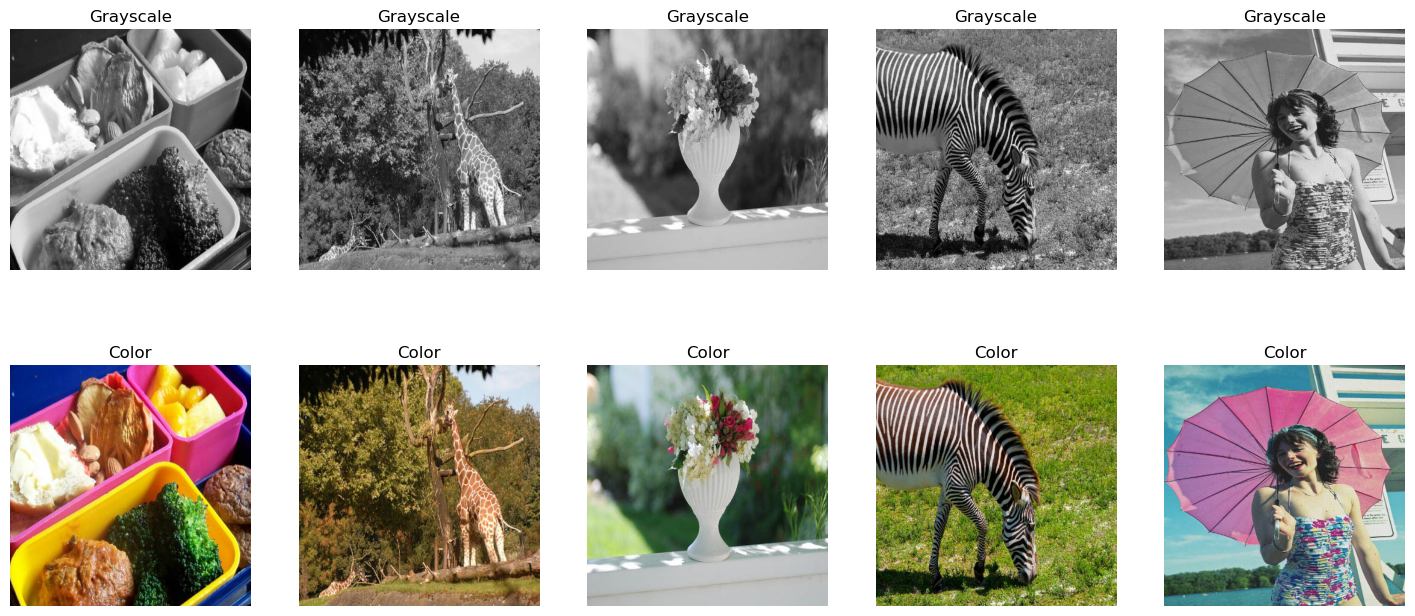

In [16]:
# Select first five images

num_images_to_display = 5

selected_colored_images = color_images_paths[:num_images_to_display]
selected_black_images = black_images_paths[:num_images_to_display]

# Loading images
color_images = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in selected_colored_images]
gray_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in selected_black_images]


def show_images(gray_images, color_images, num_images = 5):
    plt.figure(figsize = (18,8))

    for i in range(num_images):

        #display gray images
        plt.subplot(2, num_images, i+1)
        plt.imshow(gray_images[i], cmap = 'gray')
        plt.axis('off')
        plt.title('Grayscale')

        # Display color image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(color_images[i])
        plt.axis('off')
        plt.title('Color')

    plt.show()

# #visualizing images
show_images(gray_images, color_images, num_images=num_images_to_display)

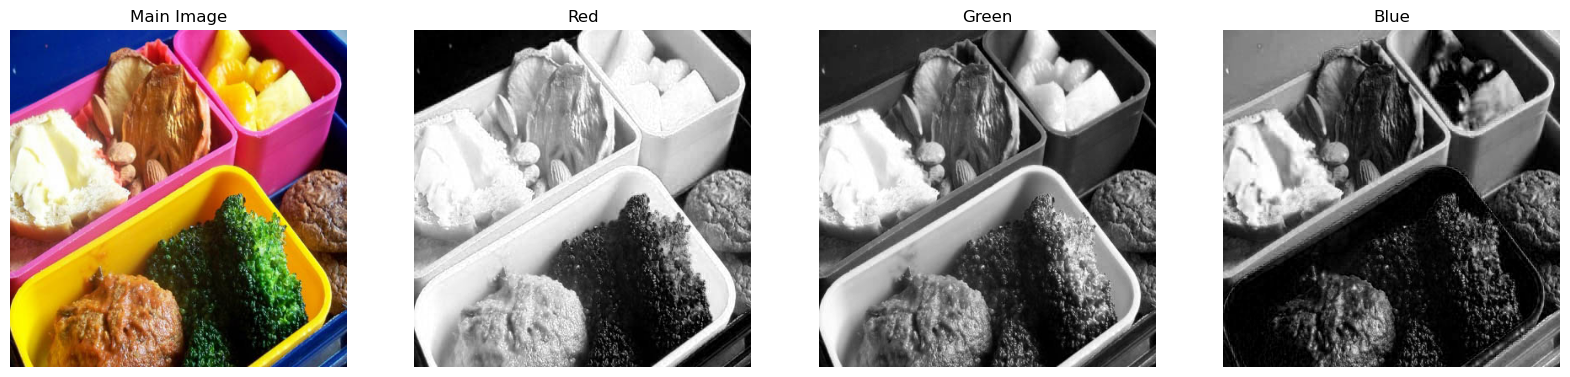

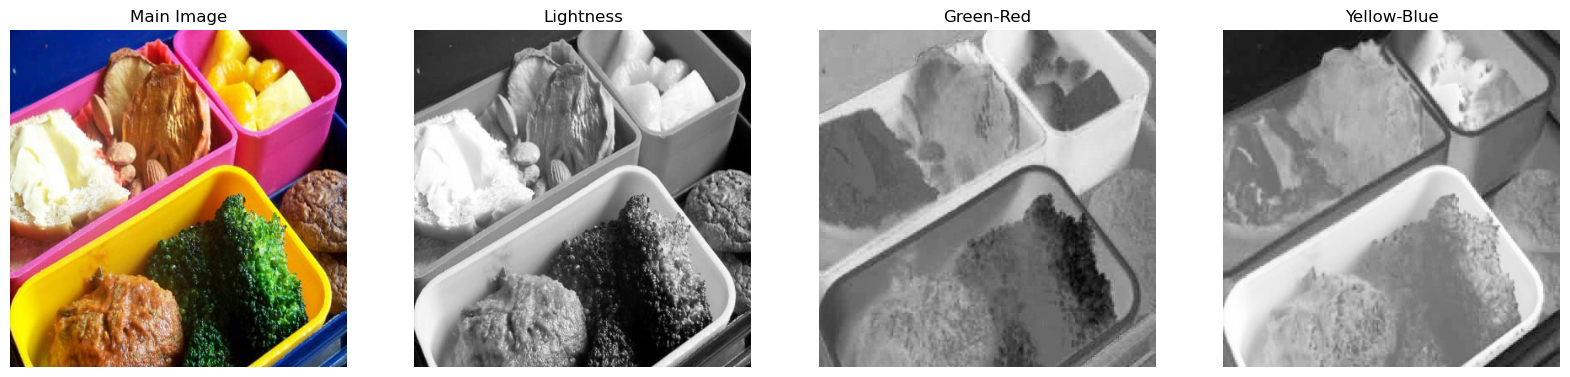

In [17]:
# Load the first color image
image_path = color_images_paths[0]
image = cv2.imread(image_path)


# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image from BGR to LAB
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Split the channels
r_channel, g_channel, b_channel = cv2.split(image_rgb)
l_channel, a_channel, b_channel_lab = cv2.split(image_lab)

# Function to display images
def display_images(main_image, channels, titles, space, is_rgb=True):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    if is_rgb:
        plt.imshow(main_image)
    else:
        plt.imshow(cv2.cvtColor(main_image, cv2.COLOR_LAB2RGB))
    plt.title('Main Image')
    plt.axis('off')

    for i, (channel, title) in enumerate(zip(channels, titles), start=2):
        plt.subplot(1, 4, i)
        plt.imshow(channel, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

# Titles for RGB and LAB channels
rgb_titles = ['Red', 'Green', 'Blue']
lab_titles = ['Lightness', 'Green-Red', 'Yellow-Blue']

# Display RGB channels
display_images(image_rgb, [r_channel, g_channel, b_channel], rgb_titles, 'Channel', is_rgb=True)

# Display LAB channels (L, A, B)
display_images(image_lab, [l_channel, a_channel, b_channel_lab], lab_titles, 'Channel', is_rgb=False)


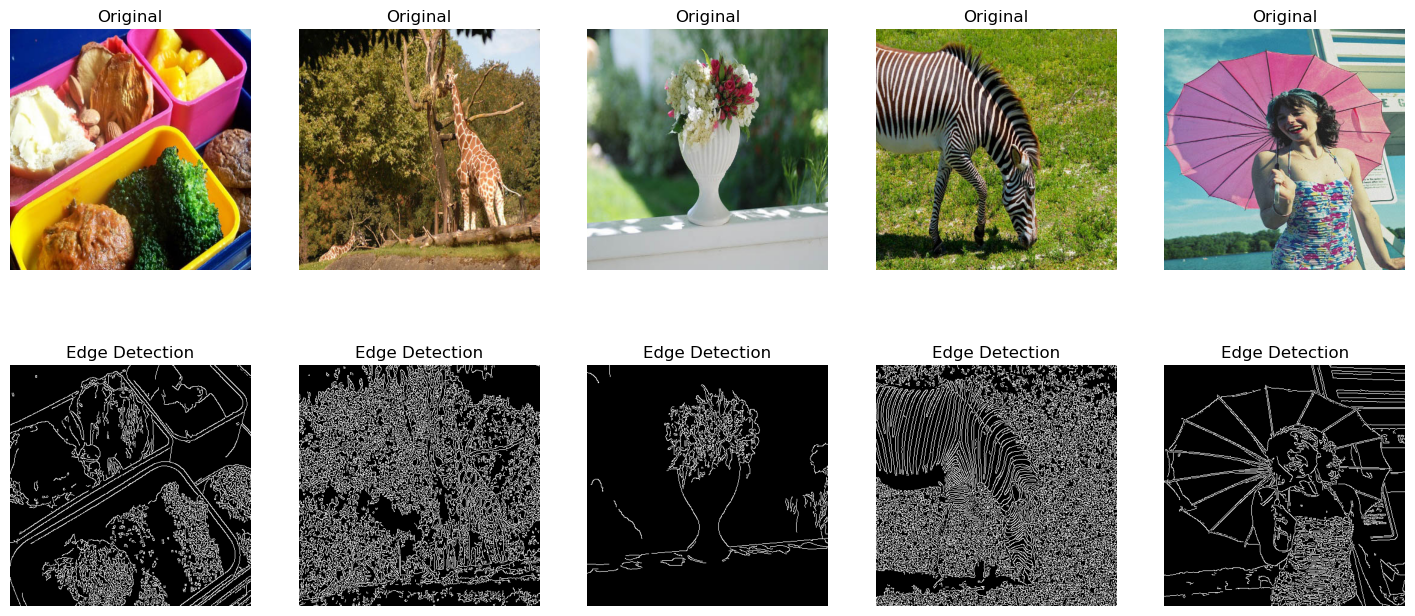

In [20]:
def extract_edges(images):
    edge_images = []
    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  # Rescale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
        edges = cv2.Canny(img, 100, 200)
        edge_images.append(edges)
    return edge_images

def display_images(images, output_images, num_images=5, title = 'Edge Detection'):
    plt.figure(figsize=(18, 8))
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title('Original')
        
        # Display edge-detected image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(output_images[i], cmap='gray')
        plt.axis('off')
        plt.title(title)
    
    plt.show()
    
edge_images = extract_edges(gray_images)

# Display the original grayscale images and their edge-detected versions
display_images(color_images, edge_images, num_images=num_images_to_display)

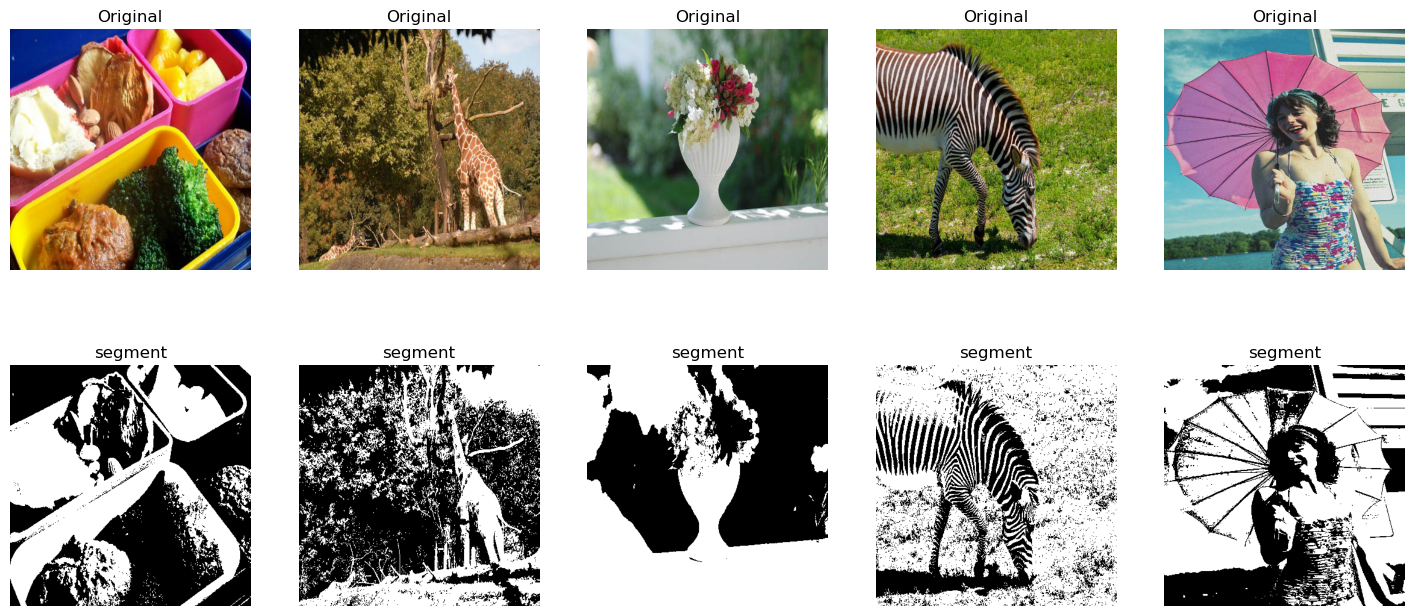

In [24]:
def apply_otsu_segmentation(images):
    segmented_images = []
    for img in images:
        # Check if image needs rescaling
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  # Rescale if needed

        # Convert to grayscale if image is in color
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply Otsu's thresholding
        _, segmented = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        segmented_images.append(segmented)
    
    return segmented_images

# Example usage:
segmented_images = apply_otsu_segmentation(gray_images)
# Display the original color images and their segmented versions
display_images(color_images, segmented_images, num_images=num_images_to_display, title='segment')



## Data Preparing



In [29]:
# Create the original dataset
dataset = create_dataset(black_images_paths, color_images_paths, target_size=(256, 256))

# Create the dataset with combined grayscale and edge-detected images
dataset_with_edges = create_dataset_with_edges(dataset)

# Create the dataset with combined grayscale and segmented images
dataset_with_segment = create_dataset_with_segment(dataset)

# Check the datasets
print("Checking original dataset:")
for gray_images, lab_images in dataset.take(1):
    print("Original Batch Size:", gray_images.shape[0])
    print("Original Grayscale Images Shape:", gray_images.shape)
    print("Original LAB Images Shape:", lab_images.shape)

print("\nChecking dataset with edges:")
for combined_images, lab_images in dataset_with_edges.take(1):
    print("With Edges Batch Size:", combined_images.shape[0])
    print("Combined Images Shape:", combined_images.shape)
    print("LAB Images Shape:", lab_images.shape)

print("\nChecking dataset with segments:")
for combined_images, lab_images in dataset_with_segment.take(1):
    print("With Segments Batch Size:", combined_images.shape[0])
    print("Combined Images Shape:", combined_images.shape)
    print("LAB Images Shape:", lab_images.shape)

Checking original dataset:
Original Batch Size: 32
Original Grayscale Images Shape: (32, 256, 256, 1)
Original LAB Images Shape: (32, 256, 256, 3)

Checking dataset with edges:
With Edges Batch Size: 32
Combined Images Shape: (32, 256, 256, 2)
LAB Images Shape: (32, 256, 256, 3)

Checking dataset with segments:
With Segments Batch Size: 32
Combined Images Shape: (32, 256, 256, 2)
LAB Images Shape: (32, 256, 256, 3)


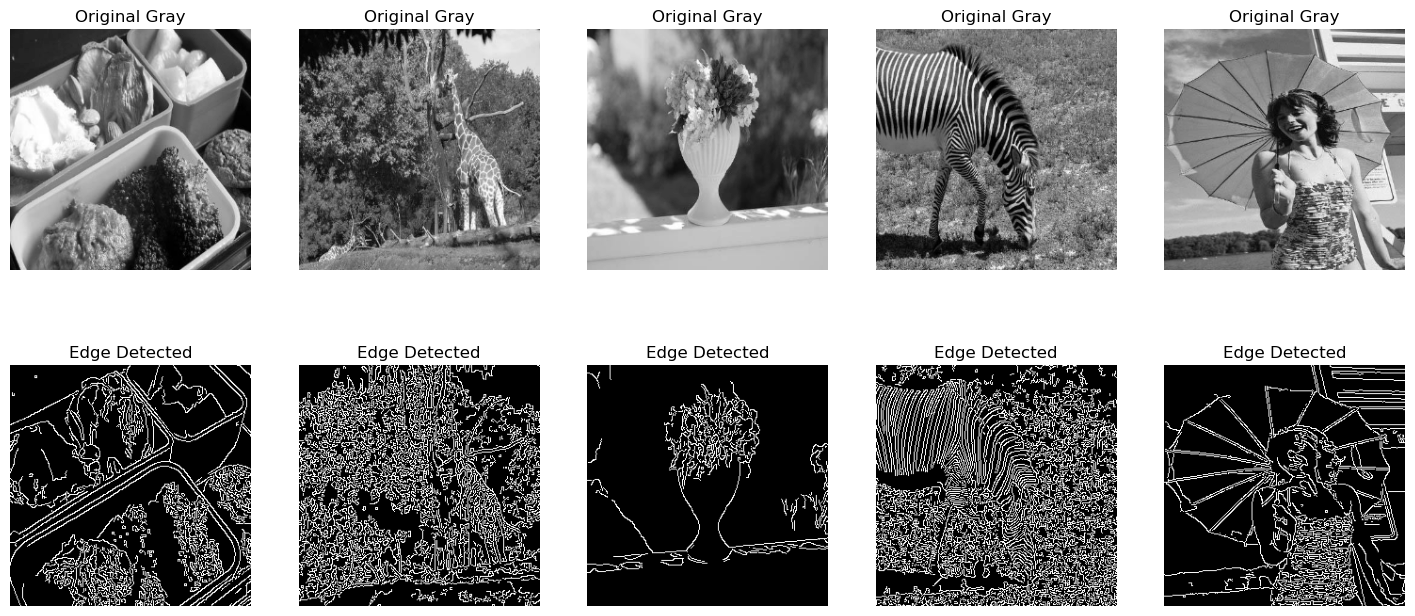

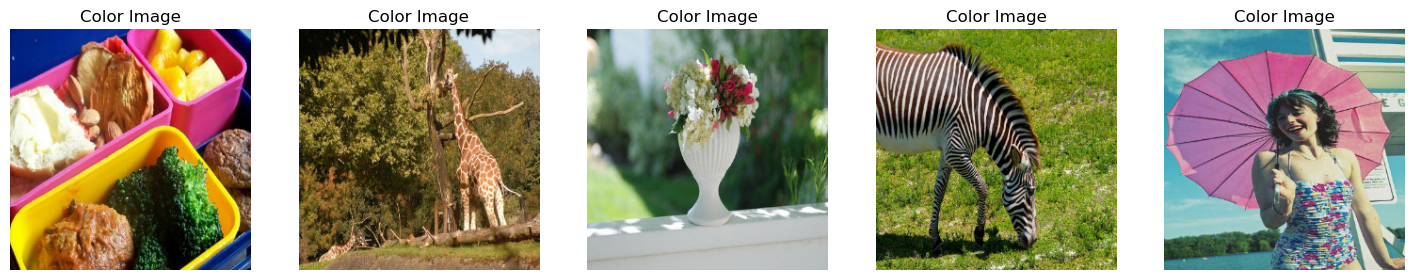

In [30]:
def extract_images_from_dataset(dataset, num_samples=1):
    gray_with_edges_list = []
    color_images_list = []
    
    for combined_images, lab_images in dataset.take(num_samples):
        if tf.executing_eagerly():
            combined_images = combined_images.numpy()
            lab_images = lab_images.numpy()
        
        gray_with_edges_list.append(combined_images)
        color_images_list.append(lab_images)
    
    gray_with_edges = np.concatenate(gray_with_edges_list, axis=0)
    color_images = np.concatenate(color_images_list, axis=0)
    
    return gray_with_edges, color_images

def display_edge_detection_results(gray_images, edge_images, num_images=5):
    plt.figure(figsize=(18, 8))
    for i in range(num_images):
        # Display original grayscale image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(gray_images[i], cmap='gray')
        plt.axis('off')
        plt.title('Original Gray')
        
        # Display edge-detected image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(edge_images[i], cmap='gray')
        plt.axis('off')
        plt.title('Edge Detected')
    plt.show()

# Extract images from the dataset_with_edges
gray_with_edges, color_images = extract_images_from_dataset(dataset_with_edges, num_samples=1)

# Separate grayscale and edge images
grayscale_images = gray_with_edges[:, :, :, 0]
edge_images = gray_with_edges[:, :, :, 1]

# Display the results
num_images_to_display = 5
display_edge_detection_results(grayscale_images, edge_images, num_images=num_images_to_display)

# If you want to display color images as well, you can use a similar function:
def display_color_images(color_images, num_images=5):
    plt.figure(figsize=(18, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(color_images[i])
        plt.axis('off')
        plt.title('Color Image')
    plt.show()

# Display color images
display_color_images(color_images, num_images=num_images_to_display)


## How to use

### This is just a demo model on how we are supposed to use above created dataset for training and testing

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Define model architecture
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust based on task
    ])
    return model

# Create datasets
train_gray_images_paths = [...]
train_color_images_paths = [...]
test_gray_images_paths = [...]
test_color_images_paths = [...]

train_dataset = create_dataset(train_gray_images_paths, train_color_images_paths)
test_dataset = create_dataset(test_gray_images_paths, test_color_images_paths)

train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model preparation
model = create_model(input_shape=(256, 256, 1))  # Adjust input shape based on your dataset

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use appropriate loss function
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,  # Number of epochs
    validation_data=test_dataset  # Use test dataset for validation
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


## U-net